### Carregando o modelo

In [3]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=c95052c46f2f93d43c5b4dcc603d247fbfb2575def4360aa9267d96d89952e99
  Stored in directory: c:\users\vduchi01\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import json
import string
import spacy
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [63]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Viabilizadores
import joblib
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline

# Feature selection & relatório de resultados
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score

In [11]:
from keras.models import load_model


In [198]:
def loadModel():
    name = input('escreva o nome do modelo a ser carregado:')
    savedModel = load_model(name)
    with open('wordIndex.json') as f:
        dicto = json.load(f)
    savedModel.summary()
    return savedModel, dicto

def loadTraditional():
    name = input('escreva o nome do modelo a ser carregado:')
    savedModel = joblib.load(name)
    print("model loaded")
    return savedModel

In [221]:
model=loadTraditional()

escreva o nome do modelo a ser carregado:SVC_7200_news_certo.pkl
model loaded


In [100]:
tokenizer = Tokenizer()
model, tokenizer.word_index = loadModel()

escreva o nome do modelo a ser carregado:treinoVec-150e500-10epo-acc94.h5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 100)          9235900   
                                                                 
 lstm_3 (LSTM)               (None, 110)               92840     
                                                                 
 dense_3 (Dense)             (None, 1)                 111       
                                                                 
Total params: 9,328,851
Trainable params: 92,951
Non-trainable params: 9,235,900
_________________________________________________________________


### Notícias analisadas - True

In [123]:
true=[]
for i in range(1,54):
    try:
        with open(r'C:\Users\vduchi01\Downloads\tcc-fake-main\tcc-fake-main\3.noticias_true_maio22\\'+str(i)+'.txt', encoding ="utf8") as t:
            true.append(t.read())
    except:
        pass

In [116]:
true

['O presiden',
 'A Comissão',
 'Os deputad',
 'A Comissão',
 'O Centro d',
 'O ex-presi',
 'O presiden',
 'O ex-presi',
 'O ministro',
 'O Ministér',
 'A Câmara d',
 'O pré-cand',
 'A Câmara d',
 'O plenário',
 'O partido ',
 'O jornalis',
 'O primogên',
 'A Comissão',
 'O Tribunal',
 'O ministro',
 'Bolsonaro ',
 'Integrante',
 'A Rússia e',
 'No laborat',
 'O presiden',
 'Os casos d',
 'O presiden',
 'O número d',
 'As mulhere',
 'Os colombi',
 'Em 1951, o',
 'Um projeto',
 'O ex-gover',
 'O presiden',
 'Parlamenta',
 'O Norte e ',
 'No momento',
 'O ministro',
 'O PT recor',
 'O PSOL pro',
 'O governo ',
 'A lei apro',
 'O ministro',
 'Integrante',
 'O Senado a',
 'O ministro',
 'O governo ',
 'Membros da',
 'A Secretar',
 'O presiden',
 'Bolsonaro ',
 'Jogar depu',
 'Bolsonaro ']

In [27]:
labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]
len(labels)

53

In [205]:
labels_2 = ['true' if item == 0 else 'fake' for item in labels]
len(labels_2)

53

In [124]:
 df = pd.DataFrame(list(zip(true,labels)),columns=['true','labels'])

### Preprocessing

In [125]:
# Carregando o pacote de língua portuguesa para o processador Spacy
nlp = spacy.load('pt_core_news_sm')

In [132]:
# Defininido funções de preprocessamento

def removePunct(text):
    '''
    Removes any punctuation included in string.punctuation.
    '''
    translator = text.maketrans({key:'' for key in string.punctuation+'“”'}) # Translates any punctuation into ''
    return text.translate(translator)

def removeNumbers(text):
    '''
    Removes any number character in text.
    '''
    return re.sub('[0-9]', '' , text) # Translates any number into ''

def removeStopWords(string):
    '''
    Removes any portuguese stopwords, using Spacy's standard package.
    '''
    doc = nlp(string)
    return ' '.join([token.text for token in doc if token.is_stop is False])

def lemmatize(string):
    '''
    Lemmatizes text word-by-word. Notice that lemmatizing is not as harsh as stemming, which makes the final text easier to read and understand in common language.
    '''
    doc = nlp(string)
    return ' '.join([token.lemma_ for token in doc])

def prep(string, useStopWords = True, lemma = True):
    '''
    Executes previously defined preprocessing in text.
    '''

    result = removeNumbers(removePunct(string)).lower()
    
    if useStopWords and lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc if token.is_stop is False])
    elif useStopWords:
        doc = nlp(result)
        result = ' '.join([token.text for token in doc if token.is_stop is False])
    elif lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc])

    result = result.replace('\n',"")
    
    return result

In [133]:
sentence_t = df['true'].apply(prep)

In [134]:
sentence_t[0]

'presidente jair bolsonaro dizer caso avancar disputa participar debate turno eleição ano entrevista apresentador Carlos massar ratinho programa rádio televisão ar Terçafeira bolsonaro falar via desistência João dor aliança  — turno ir participar turno gente pensar   candidato querer pancar eu ir responder achar debate dever pergunta préacertar baixar — dizer bolsonaro apresentador  último pesquisa datafolha apontar expresidente Luiz inácio Lula Silva pt seguir liderança corrida presidência bolsonaro pl colocação lula aparecer   intenção voto bolsonaro   margem erro  questionar apresentador opinião saída João dor psdb disputa eleitoral bolsonaro responder  — diferença saída doria tar casa   achar eleitor decidir polarizado dificilmente ter via — dizer presidente '

In [53]:
sentence_t.head()

0    o presidente jair bolsonaro disse que caso ava...
1    a comissão de constituição e justiça da câmara...
2    os deputados anunciaram na mesma sessão um aco...
3    a comissão da constituição e justiça ccj do se...
4    o centro de contingência do coronavírus no est...
Name: true, dtype: object

### Classificação Trues

In [135]:
lista_t = sentence_t.to_list()

In [136]:
lista_t[0]

'presidente jair bolsonaro dizer caso avancar disputa participar debate turno eleição ano entrevista apresentador Carlos massar ratinho programa rádio televisão ar Terçafeira bolsonaro falar via desistência João dor aliança  — turno ir participar turno gente pensar   candidato querer pancar eu ir responder achar debate dever pergunta préacertar baixar — dizer bolsonaro apresentador  último pesquisa datafolha apontar expresidente Luiz inácio Lula Silva pt seguir liderança corrida presidência bolsonaro pl colocação lula aparecer   intenção voto bolsonaro   margem erro  questionar apresentador opinião saída João dor psdb disputa eleitoral bolsonaro responder  — diferença saída doria tar casa   achar eleitor decidir polarizado dificilmente ter via — dizer presidente '

In [137]:
maxlen = 100
sequences_t = tokenizer.texts_to_sequences(sentence_t)
padded_t = pad_sequences(sequences_t, maxlen=maxlen, padding='post',truncating='pre')

In [139]:
len(padded_t[0])

100

In [102]:
for i in range(0,50):
    print(len(sequences_t[i]))

200
372
318
599
177
194
317
432
258
520
181
223
346
538
268
358
247
473
358
189
403
178
235
903
283
321
310
159
450
442
294
1482
573
797
1351
1194
1711
354
445
380
251
270
368
210
434
365
454
218
546
454


Rodar no Tradicional

In [141]:
lista_2 = [item.split() for item in lista_t]

In [142]:
lista_2

[['presidente',
  'jair',
  'bolsonaro',
  'dizer',
  'caso',
  'avancar',
  'disputa',
  'participar',
  'debate',
  'turno',
  'eleição',
  'ano',
  'entrevista',
  'apresentador',
  'Carlos',
  'massar',
  'ratinho',
  'programa',
  'rádio',
  'televisão',
  'ar',
  'Terçafeira',
  'bolsonaro',
  'falar',
  'via',
  'desistência',
  'João',
  'dor',
  'aliança',
  '—',
  'turno',
  'ir',
  'participar',
  'turno',
  'gente',
  'pensar',
  'candidato',
  'querer',
  'pancar',
  'eu',
  'ir',
  'responder',
  'achar',
  'debate',
  'dever',
  'pergunta',
  'préacertar',
  'baixar',
  '—',
  'dizer',
  'bolsonaro',
  'apresentador',
  'último',
  'pesquisa',
  'datafolha',
  'apontar',
  'expresidente',
  'Luiz',
  'inácio',
  'Lula',
  'Silva',
  'pt',
  'seguir',
  'liderança',
  'corrida',
  'presidência',
  'bolsonaro',
  'pl',
  'colocação',
  'lula',
  'aparecer',
  'intenção',
  'voto',
  'bolsonaro',
  'margem',
  'erro',
  'questionar',
  'apresentador',
  'opinião',
  'saída'

In [189]:
lista_3 = [noticia[0:100] for noticia in lista_2] #if len(noticia)>100]

In [190]:
len(lista_3)

53

In [180]:
for i in range (0,53):
    print(len(lista_3[i]))
    

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


IndexError: list index out of range

In [182]:
flat_list = [x for xs in lista_3 for x in xs]

In [183]:
flat_list

['presidente',
 'jair',
 'bolsonaro',
 'dizer',
 'caso',
 'avancar',
 'disputa',
 'participar',
 'debate',
 'turno',
 'eleição',
 'ano',
 'entrevista',
 'apresentador',
 'Carlos',
 'massar',
 'ratinho',
 'programa',
 'rádio',
 'televisão',
 'ar',
 'Terçafeira',
 'bolsonaro',
 'falar',
 'via',
 'desistência',
 'João',
 'dor',
 'aliança',
 '—',
 'turno',
 'ir',
 'participar',
 'turno',
 'gente',
 'pensar',
 'candidato',
 'querer',
 'pancar',
 'eu',
 'ir',
 'responder',
 'achar',
 'debate',
 'dever',
 'pergunta',
 'préacertar',
 'baixar',
 '—',
 'dizer',
 'bolsonaro',
 'apresentador',
 'último',
 'pesquisa',
 'datafolha',
 'apontar',
 'expresidente',
 'Luiz',
 'inácio',
 'Lula',
 'Silva',
 'pt',
 'seguir',
 'liderança',
 'corrida',
 'presidência',
 'bolsonaro',
 'pl',
 'colocação',
 'lula',
 'aparecer',
 'intenção',
 'voto',
 'bolsonaro',
 'margem',
 'erro',
 'questionar',
 'apresentador',
 'opinião',
 'saída',
 'João',
 'dor',
 'psdb',
 'disputa',
 'eleitoral',
 'bolsonaro',
 'responder'

In [191]:
lista_4=[]
for i in lista_3:
    lista_4.append(' '.join(i))

In [192]:
lista_4

['presidente jair bolsonaro dizer caso avancar disputa participar debate turno eleição ano entrevista apresentador Carlos massar ratinho programa rádio televisão ar Terçafeira bolsonaro falar via desistência João dor aliança — turno ir participar turno gente pensar candidato querer pancar eu ir responder achar debate dever pergunta préacertar baixar — dizer bolsonaro apresentador último pesquisa datafolha apontar expresidente Luiz inácio Lula Silva pt seguir liderança corrida presidência bolsonaro pl colocação lula aparecer intenção voto bolsonaro margem erro questionar apresentador opinião saída João dor psdb disputa eleitoral bolsonaro responder — diferença saída doria tar casa achar eleitor decidir polarizado dificilmente ter via',
 'comissão constituição Justiça Câmara ccj adiar terçafeira votação requerimento convocação ministro Justiça Anderson Torres explique assassinato genivaldo jesus santo abordagem polícia Rodoviária federal prf Sergipe presidente colegiado Arthur Maia união

In [193]:
def removeMinFreq(data, features, min_freq = 1):
    # Realiza a soma da frequência de cada palavra da matriz vetorizada
    cols_sum = np.sum(data, axis=0)

    del_indexes = []
    # Analisa cada valor das contagens de frequência do cols_sum, assignando um índice i, e salva o índice em del_indexes[]
    # quando a contagem for acima da min_freq
    for i, val in zip(range(len(cols_sum)), cols_sum):
        if val < min_freq:
            del_indexes.append(i)
            
    data = np.delete(data,del_indexes,1) # Deleta coluna
    features = np.delete(features,del_indexes,0) # Deleta linha
    return (data, features)


def normalizeData(data):
    rows_sum = np.sum(data, axis=1)
    data = (data.T / rows_sum).T
    return data

def loadCount(texts, min_freq = 1, binary = False, normalize = True):

    # Instanciando o CountVectorizer
    vectorizer = CountVectorizer(input = 'content', preprocessor = prep, encoding='utf-8', binary = binary);
    
    # Aplicando processo de vetorização
    data = np.array(vectorizer.fit_transform(lista_4).todense());
    features = np.array(vectorizer.get_feature_names())
    
    # Se min_freq for 1, então todos os tokens são considerados
    if(min_freq > 1):
        data, features = removeMinFreq(data, features, min_freq)
    if(normalize):
        data = normalizeData(data)

    return pd.DataFrame(data,columns = features)

In [194]:
df_bow = loadCount(lista_4, normalize = False)
#df_tfidf = loadTfidf(text_list)

In [217]:
df_bow

,Abril,Adolfo,Agenr,Agricultura,Alckmin,Alemanha,Alexandre,Anatel,Anderson,André,...,época,ética,êxito,índice,índio,óbito,óleo,órgão,ótima,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
feature_selection = 100

X_best = SelectKBest(mutual_info_classif,k=feature_selection).fit_transform(df_bow,df['labels'])

#predictions = (cross_val_predict(model, X_best, df['labels'], cv=3))


In [222]:
predictions = model.predict(X_best)

In [223]:
target_name = ['Falsas','Verdadeiras']
print(classification_report(labels_2, predictions, target_names=target_name))

              precision    recall  f1-score   support

      Falsas       0.02      0.33      0.04         3
 Verdadeiras       0.00      0.00      0.00        50

    accuracy                           0.02        53
   macro avg       0.01      0.17      0.02        53
weighted avg       0.00      0.02      0.00        53



In [214]:
cm = tf.math.confusion_matrix(labels=labels_2,predictions=predictions)

UnimplementedError: Cast string to int64 is not supported [Op:Cast]

Text(69.0, 0.5, 'Truth')

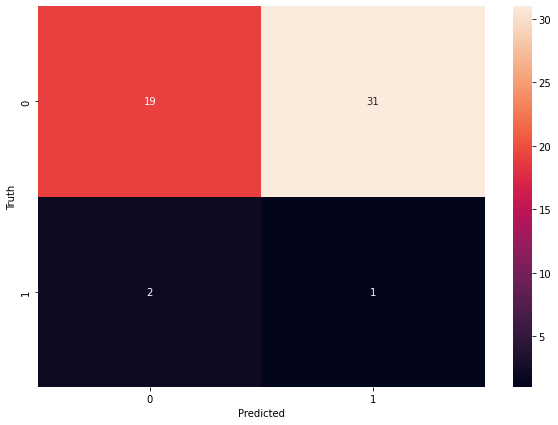

In [215]:
plt.figure(figsize= (10,7))
sns.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Rede Neural

In [140]:
y_pred = (model.predict(padded_t) >=0.5).astype(int)

2/2 [==============================] - 1s 56ms/step


In [95]:
for i in range(0,50):
    print(y_pred[i])

[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]


In [104]:
print(accuracy_score(labels, y_pred))
print(precision_score(labels, y_pred))
print(recall_score(labels, y_pred))
print(f1_score(labels, y_pred))

0.37735849056603776
0.03125
0.3333333333333333
0.05714285714285714


In [105]:
target_name = ['Verdadeiras','Falsas']
print(classification_report(labels, y_pred, target_names=target_name))

              precision    recall  f1-score   support

 Verdadeiras       0.90      0.38      0.54        50
      Falsas       0.03      0.33      0.06         3

    accuracy                           0.38        53
   macro avg       0.47      0.36      0.30        53
weighted avg       0.86      0.38      0.51        53



In [106]:
cm = tf.math.confusion_matrix(labels=labels,predictions=y_pred)

Text(69.0, 0.5, 'Truth')

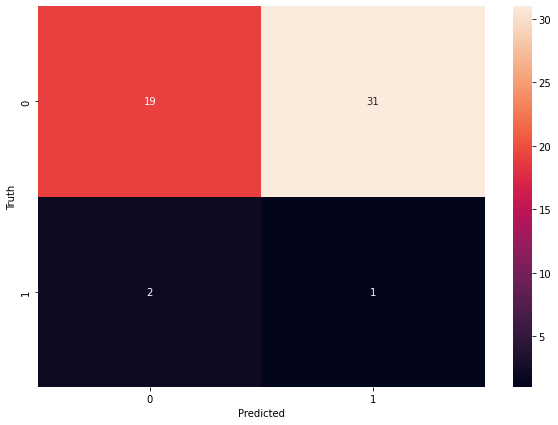

In [107]:
plt.figure(figsize= (10,7))
sns.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Classificação Fakes

In [82]:
lista_f = []
lista_f.append(sentence_f)
lista_f

['quatro expresidentes presos até é o que a lava jato está preparando a força tarefa da operação lava jato está com farto material acusatório para levar para a cadeia simultaneamente expresidentes do brasil lula dilma temer e collor podem terminar sua vida política atrás das gradesa condenação de lula acendeu o alerta vermelho em políticos que se achavam intocáveis a operação lava jato ao condenar o maior líder político da esquerda no brasil demonstrou que nenhuma pessoa está acima da leia condenação a nove anos e seis meses de prisão pelo juiz federal sergio moro nesta quartafeira não mandará o petista automaticamente para a cadeia isso porque moro é um juiz de primeira instância e assim sua decisão não basta para que a pena seja cumprida imediatamentetoda decisão que o \x93juiz da lava jato\x94 toma em primeira instância é depois revisada em segunda instância pelos desembargadores do tribunal regional da a região trf joão pedro gebran neto relator da operação leandro paulsen e victor

In [103]:
maxlen = 100
sequences_f = tokenizer.texts_to_sequences(lista_f)
padded_f = pad_sequences(sequences_f, maxlen=maxlen)

In [104]:
model.predict(padded_f)

array([[0.9640597]], dtype=float32)

In [85]:
(model.predict(padded_f) >=0.5).astype(int)

array([[1]])